In [57]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
from clean_data import *
import os
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# Exploratory Data Analysis

After crawling the data, we have 950 samples. Firstly, we noted that the salaries are in different forms, some are based on hour/year, and some are in a range such as 70-80 an hour, etc. Therefore, we converted them into salary based on year.

In [58]:
job_salary = pd.read_csv("data.csv")
job_salary.salary

0      $36.45 - $43.04 an hour
1                  $43 an hour
2                  $28 an hour
3                  $46 an hour
4               $34.50 an hour
                ...           
945          $70 - $80 an hour
946            $120,000 a year
947             $40.35 an hour
948             $40.10 an hour
949                $35 an hour
Name: salary, Length: 950, dtype: object

In [59]:
job_salary = pd.read_csv("data.csv")
job_salary_cleaned = clean_requirements(job_salary)
job_salary_cleaned = convert_salary(job_salary)
job_salary_cleaned.salary

0      100157.4
1      108360.0
2       70560.0
3      115920.0
4       86940.0
         ...   
945    189000.0
946    120000.0
947    101682.0
948    101052.0
949     88200.0
Name: salary, Length: 950, dtype: float64

## Distribution of the salary



 We observed that most salaries are in between 50K to 100K, which agree with our intuition. 

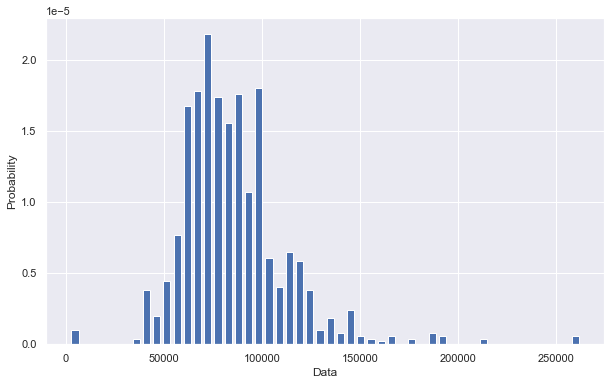

In [60]:
salary = job_salary_cleaned.salary.tolist()
plt.figure(figsize=(10,6))
plt.hist(salary,density=True, bins=50,rwidth=0.7)
plt.ylabel('Probability')
plt.xlabel('Data') 
plt.show()

Next, We split the salaries into five ranges: <50K, 50-75K, 75-100K, 100-150K, >150K.

In [61]:
# divide salary into 5 buckets
def salary_bucket(salary):
    if salary < 50000:
        return '<50,000'
    if salary >= 50000 and salary < 75000:
        return '50,000-75,000'
    elif salary >= 75000 and salary < 100000:
        return '75,000-100,000'
    elif salary >=100000 and salary <= 150000:
        return '10,0000-15,0000'
    else:
        return '>150,000'
    
job_salary_cleaned['salary_buckets'] = job_salary_cleaned['salary'].apply(lambda x: salary_bucket(x))

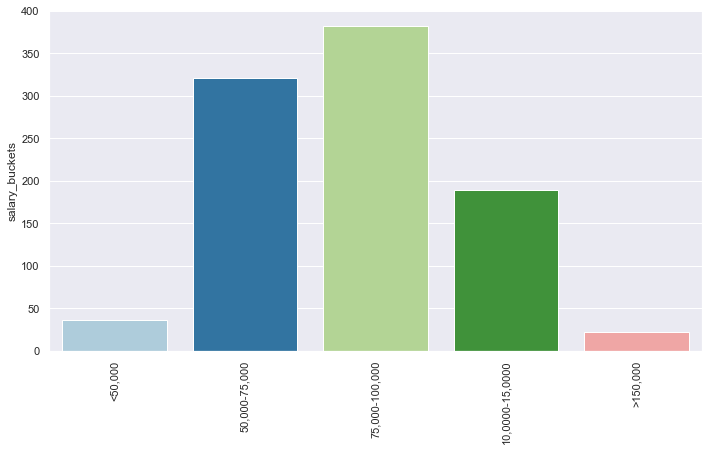

In [62]:
buckets_count = job_salary_cleaned['salary_buckets'].value_counts()
# distribution of classes
# [3, 1, 0, 2, 4] is used to list classes in ascending order
sns.set(rc={'figure.figsize':(11.7,6.27)}) 
sns.barplot(x=buckets_count.index[[3,1,0,2,4]], y=buckets_count[[3,1,0,2,4]], palette="Paired")
plt.xticks(rotation=90)
plt.show()

## Preliminary analysis

Before builing the models, we would like to have a preliminary analysis on the feautres.

In particular, we want to have some sense about how these features affect the salary by just doing some basic visualization.

### Location feature

For each province, and city. We calcuted the average salaries. We can observed that in each province, the average salary is different. ON and BC have higher salaries than other province. And the average salary of remote jobs is the highest.

However, the difference among different province is not very obvious. Instead, we looked at the average salary on each city. The difference is now obvious, some cities has avg salary higher than 100K, and some others are lower than 60K.




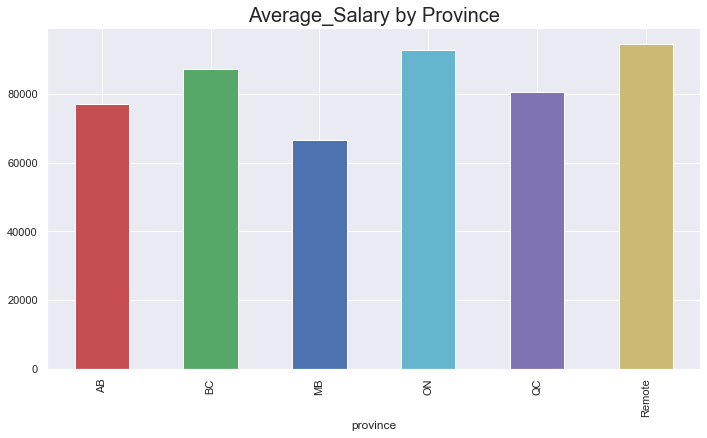

In [63]:
data = job_salary_cleaned
data = clean_location(data)
my_colors = 'rgbcmyk' 
mean_salary = data.groupby(['province']).mean()
mean_salary.plot(kind='bar',color=my_colors,legend=False)
plt.title("Average_Salary by Province", fontsize =20)
plt.show()

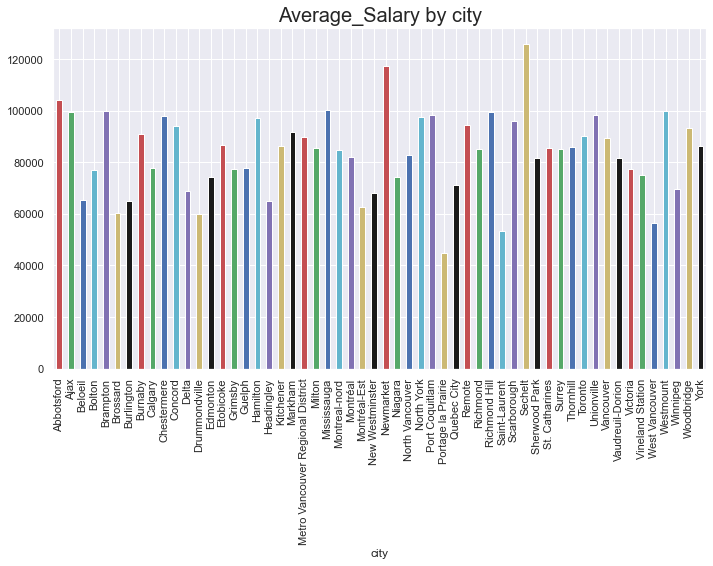

In [64]:
mean_salary = data.groupby(['city']).mean()
mean_salary.plot(kind='bar',color=my_colors,legend=False)
plt.title("Average_Salary by city", fontsize =20)
plt.show()

### Job requirements feature



In order to extract features from requirement text. We need a nature language processing (NLP) method to handle with text data. Term frequency-inverse document frequency (TF-IDF) is one of popular NLP methods. It can reflect how important a word is to a document in a corpus. Compared to bag of words, another popular NLP method, TF-IDF reduces the importance of some frequently occurring terms like we, need or have which may not be included in stop words. If a term appears in every observation, it has no contribution to the model. Thus, we decided to use TF-IDF to extract features. In python, sklearn library has a function called TFidfVectorizer. It can calculate TF-IDF of terms in each document. Because some bigrams like machine learning or deep learning may be important to predict the salary, we extracted both unigram and bigram at the same time, and we only selected top 1,000 features. Because we only have 1000 data, if we included all features, the dimension of the data will be too large. 

The following two images show top 50 words in selected features. 

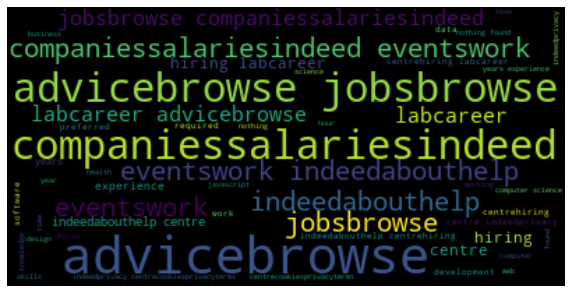

In [65]:
# extract features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = data['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

amount = words_df.sum(axis=0)
top50 = xxx.nlargest(50)
df = top50.to_frame().reset_index()
df.columns = ['word', 'count']
words = dict(zip(df['word'].tolist(), df['count'].tolist()))

wc = WordCloud().generate_from_frequencies(words)

plt.figure(figsize=(10, 10))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

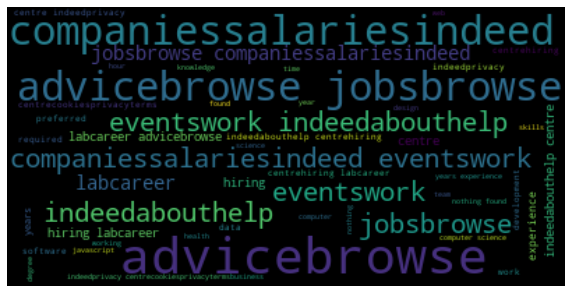

In [56]:
high_salary = data.loc[data['salary'] >100000]
# extract features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = high_salary['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

amount = words_df.sum(axis=0)
top50 = xxx.nlargest(50)
df = top50.to_frame().reset_index()
df.columns = ['word', 'count']
words = dict(zip(df['word'].tolist(), df['count'].tolist()))
wc = WordCloud().generate_from_frequencies(words)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

They are pretty similar no matter if the condition salary > 10K is added or not. The words like advicebrowse, companiessalariesindeed, eventswork have large overall TF-IDF values in corpus but they don’t make any sense for job hunters. In this case, we need to build the models to explore the relationship between features and salary.

### Category feature
In the data crawling step, we crawled salaries for 5 different job categories. and we see that at the current time, most jobs are still about software and development.

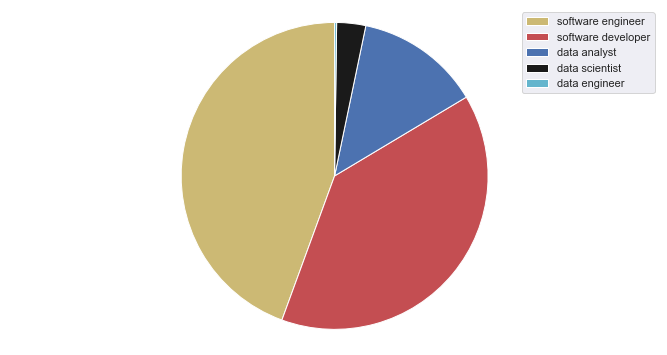

In [49]:
category = pd.DataFrame(job_salary['job_category'].value_counts()).reset_index()
category.columns = ['category', 'amount']
cat = category['category'] ; amount = category['amount']
colors = 'yrbkc' 

explode = (0, 0, 0, 0, 0)  
wedges, texts = plt.pie(amount, colors = colors, startangle=90, explode=explode)
plt.axis('equal') 
plt.legend(wedges, cat, loc="best")
plt.show()


Since there are not many examples of the job such as data scientist and data engineer, it is not very useful to compare the mean salary of different category, but from the scatter plots, we can still realize that most jobs from different categories are in the similar range.

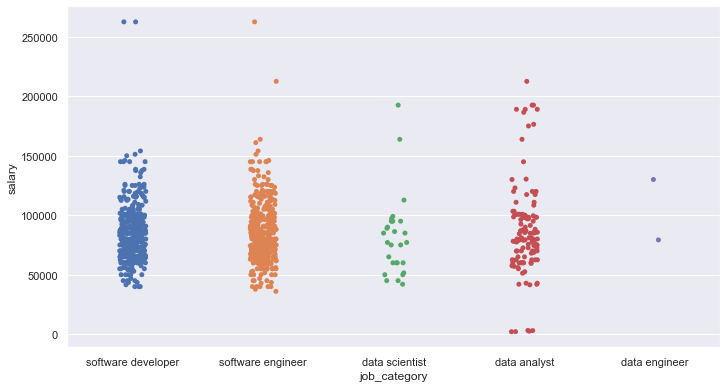

In [38]:
sns.stripplot(x="job_category", y="salary", data=job_salary_cleaned) 
plt.show()

## Model Selection

In the project, we tried logistic regression, K nearest neighbor, and random forest which are three popular models to solve classification problems.  Logistic regression as a basic classification model is commonly used in our work based on the 2019 Kaggle ML and Data Science Survey so we decided to use it as one of models to predict salary based on extracted features. In the survey, the secondary popular algorithm is tree ensemble algorithm. In addition, random forest uses bootstrap method to build trees, which can reduce the impact of imbalanced data. Besides, it can compute the importance of features so we can know which skills affect the salary. The reason that we tried KNN is because KNN is power to solve multiclassification problems and it is easy to understand. In order to make sure the final model is generalized, we split the dataset into training set and test set, and test set has 20% data. For the evaluation metric, we chose weighted F1 score because the target has 5 imbalanced classes. Compared to regular macro F1 score, weighted F1 score takes the weighted average to the value. In this case, the impact between imbalanced classes is eliminated. Additionally, we used grid search and cross validation to tune hyperparameters. First, we used job category, location and 1000 extracted features to build the models. 

### Models including job_category and location

In [7]:
# drop useless columns
full_data = clean_location(job_salary_cleaned)
mod_data = full_data.drop(columns=['job_title', 'company_name', 'requirements', 'industry', 'requirements_cleaned'])
mod_data = pd.get_dummies(data=mod_data, columns=['job_category','city', 'province'])
mod_data =mod_data.drop(columns=['salary', 'salary_buckets'])

In [8]:
# extract features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = full_data['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

In [9]:
# split the data
X = pd.concat([mod_data, words_df], axis=1)
Y = full_data['salary_buckets']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=20, test_size=0.2)

In [10]:
# logistic regression
mod_log = LogisticRegression()
c = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 100, 200, 500, 1000]
parameters = {'C': c}
metric = make_scorer(f1_score, average='weighted')
grid_log = GridSearchCV(mod_log, parameters, scoring=metric, cv=5)
grid_log = grid_log.fit(xtrain, ytrain)
opt_log = grid_log.best_estimator_
print("The optimal logistic regression model: \n", opt_log)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_log.best_score_))

The optimal logistic regression model: 
 LogisticRegression(C=100)
The mean accuracy score is 0.6718115684649897.


In [11]:
# KNN
mod_knn = KNeighborsClassifier()
neighbors = np.array(range(5, 50, 5))
parameters = {'n_neighbors': neighbors, 'weights': ['uniform', 'distance']}
metric = make_scorer(f1_score, average='weighted')
grid_knn = GridSearchCV(mod_knn, parameters, scoring=metric, cv=5)
grid_knn = grid_knn.fit(xtrain, ytrain)
opt_knn = grid_knn.best_estimator_
print("The optimal SVM model: \n", opt_knn)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_knn.best_score_))

The optimal SVM model: 
 KNeighborsClassifier(n_neighbors=10, weights='distance')
The mean accuracy score is 0.4350239797939933.


In [12]:
# random forest
mod_rf = RandomForestClassifier(random_state=44)
numTrees = np.array(range(50, 500, 50))
parameters = {'n_estimators': numTrees}
metric = make_scorer(f1_score, average='weighted')
grid_rf = GridSearchCV(mod_rf, parameters, scoring=metric, cv=5)
grid_rf = grid_rf.fit(xtrain, ytrain)
opt_rf = grid_rf.best_estimator_
print("The optimal random forest model: \n", opt_rf)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_rf.best_score_))

The optimal random forest model: 
 RandomForestClassifier(n_estimators=50, random_state=44)
The mean accuracy score is 0.6465241969245556.


In [40]:
score_df = pd.DataFrame(np.array([grid_log.best_score_, grid_knn.best_score_, grid_rf.best_score_]), 
                        columns=['F1 score'],
                        index=['Logistic Regression', 'KNN', 'Random Forest'])
score_df

,F1 score
Logistic Regression,0.671812
KNN,0.435024
Random Forest,0.646524


In [39]:
print("The weighted macro f1 socre of the optimal logistic regression model is", 
      f1_score(ytest, opt_log.predict(xtest), average='weighted'), ".")

The weighted macro f1 socre of the optimal logistic regression model is 0.6791827294591143 .


By comparing their F1 score, we found the logistic regression model gives the highest score among these three models. On the training set, the score of the random forest is 67.18%. On the test set, the score of the random forest is 67.92%. Its training score and test score are closed, which means no overfitting occurred. 

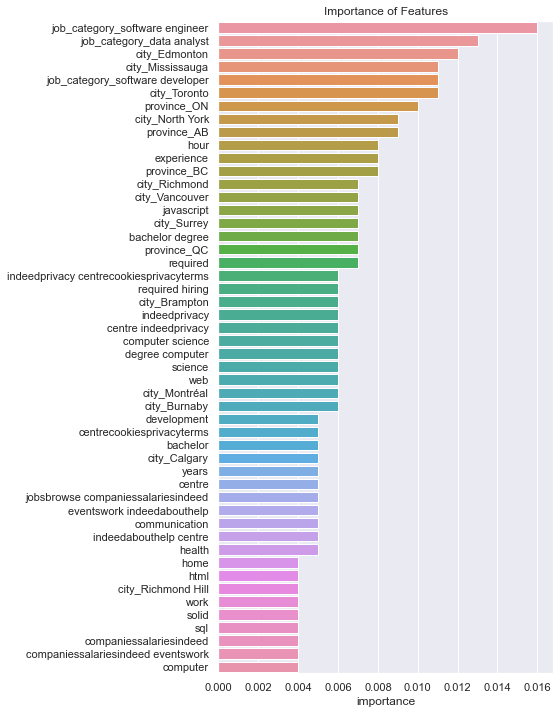

In [24]:
# visualize feature importance based on TF-IDF
# create feature importance data frame
df = pd.DataFrame(opt_rf.feature_importances_, columns=["importance"],
                  index=X.columns)
# sort by importance
df = df.sort_values('importance', ascending=False)
# plot top 20 features
plt.figure(figsize = (6,12))
sns.barplot(x=np.round(df.importance, 3)[0:50], y=df.index[0:50])
plt.title("Importance of Features")
plt.show()

However, when we looked the feature importance, we found the most top important features are job categories and locations, which make sense because the salary must be influenced by them. However, the aim of the project is to find which skills are important for job hunters. In this case, we decided to exclude job category and location when we fitted models. 

In [25]:
# # bulid a confusion matrix
# cm = confusion_matrix(ytest, opt_rf.predict(xtest), 
#                       labels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
# # plot the confusion matrix
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
#             xticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'], 
#             yticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for salary buckets")
# plt.show()

### Model selection excluding job_category and location

In [26]:
# when job_category and location are excluded
mod_data = full_data.drop(columns=['job_title', 'company_name', 'requirements', 'industry', 'requirements_cleaned'])
mod_data = mod_data.drop(columns=['job_category', 'city', 'province'])
mod_data =mod_data.drop(columns=['salary', 'salary_buckets'])

In [27]:
# split the data
X = pd.concat([mod_data, words_df], axis=1)
Y = full_data['salary_buckets']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=20, test_size=0.2)

In [28]:
# logistic regression
mod_log = LogisticRegression()
c = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 100, 200, 500, 1000]
parameters = {'C': c}
metric = make_scorer(f1_score, average='weighted')
grid_log = GridSearchCV(mod_log, parameters, scoring=metric, cv=5)
grid_log = grid_log.fit(xtrain, ytrain)
opt_log = grid_log.best_estimator_
print("The optimal logistic regression model: \n", opt_log)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_log.best_score_))

The optimal logistic regression model: 
 LogisticRegression(C=200)
The mean accuracy score is 0.654518966098511.


In [29]:
# KNN
mod_knn = KNeighborsClassifier()
neighbors = np.array(range(5, 50, 5))
parameters = {'n_neighbors': neighbors, 'weights': ['uniform', 'distance']}
metric = make_scorer(f1_score, average='weighted')
grid_knn = GridSearchCV(mod_knn, parameters, scoring=metric, cv=5)
grid_knn = grid_knn.fit(xtrain, ytrain)
opt_knn = grid_knn.best_estimator_
print("The optimal SVM model: \n", opt_knn)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_knn.best_score_))

The optimal SVM model: 
 KNeighborsClassifier(n_neighbors=20, weights='distance')
The mean accuracy score is 0.6249661711950978.


In [30]:
# random forest
mod_rf = RandomForestClassifier(random_state=44)
numTrees = np.array(range(50, 500, 50))
parameters = {'n_estimators': numTrees}
metric = make_scorer(f1_score, average='weighted')
grid_rf = GridSearchCV(mod_rf, parameters, scoring=metric, cv=5)
grid_rf = grid_rf.fit(xtrain, ytrain)
opt_rf = grid_rf.best_estimator_
print("The optimal random forest model: \n", opt_rf)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_rf.best_score_))

The optimal random forest model: 
 RandomForestClassifier(n_estimators=50, random_state=44)
The mean accuracy score is 0.6503677770211378.


In [31]:
score_df = pd.DataFrame(np.array([grid_log.best_score_, grid_knn.best_score_, grid_rf.best_score_]), 
                        columns=['F1 score'],
                        index=['Logistic Regression', 'KNN', 'Random Forest'])
score_df

,F1 score
Logistic Regression,0.654519
KNN,0.624966
Random Forest,0.650368


As shown in the table, compared to previous models, the scores of the new models slightly lower but the logistic regression model still gives the highest score on the training set. 

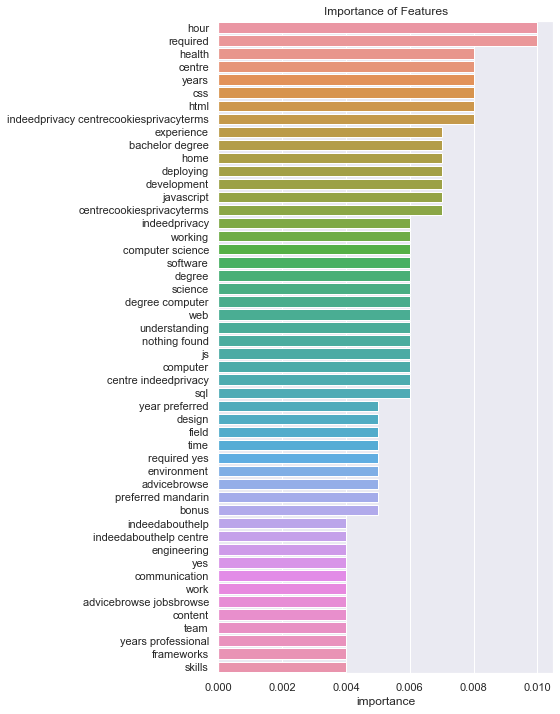

In [32]:
# visualize feature importance based on bag of wrods
# create feature importance data frame
df = pd.DataFrame(opt_rf.feature_importances_, columns=["importance"],
                  index=X.columns)
# sort by importance
df = df.sort_values('importance', ascending=False)
# plot top 20 features
plt.figure(figsize = (6,12))
sns.barplot(x=np.round(df.importance, 3)[0:50], y=df.index[0:50])
plt.title("Importance of Features")
plt.show()

When we looked the feature importance again, we found the programming language like javascript, html, sql, and css are important. Besides, the degree in computer science has a significant impact on the salary as well. Moreover, the score of the logistic regression model on the test set is 65.34%.

In [33]:
print("The weighted macro f1 socre of the optimal random forest model is", 
      f1_score(ytest, opt_log.predict(xtest), average='weighted'), ".")

The weighted macro f1 socre of the optimal random forest model is 0.653350443002876 .


In [34]:
# # bulid a confusion matrix
# cm = confusion_matrix(ytest, opt_rf.predict(xtest), 
#                       labels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
# # plot the confusion matrix
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
#             xticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'], 
#             yticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for salary buckets")
# plt.show()